In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("./data/point/images"))

['A1l', 'A2l', 'A3l', 'Adl', 'Ael', 'FAL', 'FBL', 'FCL', 'FDL', 'FEL', 'FFL', 'Fgl', 'Fhl', 'Fil', 'Fll', 'Fml', 'Gal', 'Gbl', 'Gcl', 'Gdl', 'Ggl', 'Gzl', 'NAL', 'NBL', 'NCL', 'NDL', 'NEL', 'New', 'NFL', 'NGL', 'NHL', 'NIL', 'NLL', 'NML']


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_dir_main = "./data/point/images/"
all_image_path = glob(os.path.join(data_dir_main, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# print(all_image_path)

# print(all_image_path)
# bkl: 'Benign keratosis-like lesions '
# akiec is missing
lesion_type_dict = {    
    "akiec": "akiec",
    'basal cell carcinoma': 'Basal cell carcinoma',
    'seborrheic keratosis': 'Benign keratosis-like lesions ',
    'dermatofibroma': 'Dermatofibroma',
    'reed or spitz nevus': 'Melanocytic nevi',
    'vascular lesion': 'Vascular lesions',
    'melanoma': 'Melanoma'
}

"""
akiec | Actinic keratoses:               0
bcc:  | Basal cell carcinoma             1
blk:  | Benign keratosis-like lesions    2
df    | Dermatofibroma:                  3
nv    | Melanocytic nevi:                4
vasc  | Vascular lesions:                5
mel:  | dermatofibroma                   6
"""

indexMap = {
    'reed or spitz nevus': 4,    # 
    'melanoma': 6,               #
    'seborrheic keratosis': 2,   # Benign keratosis-like lesions 
    'basal cell carcinoma': 1,   # Basal cell carcinoma
    'vascular lesion': 5,        # Vascular lesions
    'dermatofibroma': 3          # Dermatofibroma
}

In [4]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [5]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|██████████| 2013/2013 [00:24<00:00, 82.03it/s]


(224, 224, 3, 2013)
normMean = [0.7260525, 0.6226033, 0.5679677]
normStd = [0.25936174, 0.26400355, 0.26698273]


In [6]:
data_dir = "./data/point/meta/"

# print(df_original['derm'][0])
# print(imageid_path_dict[df_original['derm'][0]])

df_original = pd.read_csv(os.path.join(data_dir, 'meta.csv'))
df_original['path'] = df_original['derm'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['diagnosis'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = df_original['diagnosis'].map(indexMap.get)
# df_original['cell_type_idx'] = pd.Categorical(df_original['diagnosis']).codes
df_original

# print(pd.Categorical(2).codes)
# print(df_original.shape)

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,...,location,sex,management,clinic,derm,case_id,notes,path,cell_type,cell_type_idx
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,...,abdomen,female,excision,NEL/NEL025.JPG,Nel026,NaN,NaN,./data/point/images\NEL\Nel026.jpg,Basal cell carcinoma,1.0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,...,head neck,female,excision,NEL/NEL027.JPG,Nel028,NaN,NaN,./data/point/images\NEL\Nel028.jpg,Basal cell carcinoma,1.0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,...,head neck,female,excision,NEL/Nel032.jpg,Nel033,NaN,NaN,./data/point/images\NEL\Nel033.jpg,Basal cell carcinoma,1.0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,...,lower limbs,male,excision,NEL/NEL034.JPG,Nel035,NaN,NaN,./data/point/images\NEL\Nel035.jpg,Basal cell carcinoma,1.0
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,...,upper limbs,female,excision,NEL/NEL036.JPG,Nel037,NaN,NaN,./data/point/images\NEL\Nel037.jpg,Basal cell carcinoma,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,1006,vascular lesion,0,absent,absent,diffuse regular,absent,regular,absent,absent,...,acral,female,no further examination,Ggl/Ggl031.jpg,Ggl032,NaN,NaN,./data/point/images\Ggl\Ggl032.jpg,Vascular lesions,5.0
1007,1007,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,...,head neck,male,no further examination,Fhl/Fhl057.jpg,Fhl058,NaN,NaN,./data/point/images\Fhl\Fhl058.jpg,Vascular lesions,5.0
1008,1008,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,...,abdomen,female,excision,Fhl/Fhl059.jpg,Fhl060,NaN,NaN,./data/point/images\Fhl\Fhl060.jpg,Vascular lesions,5.0
1009,1009,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,...,head neck,male,clinical follow up,Fil/Fil081.jpg,Fil082,NaN,NaN,./data/point/images\Fil\Fil082.jpg,Vascular lesions,5.0


In [7]:
# df_undup = df_original[df_original['cell_type_idx'] != 'NaN']
# df_undup = df_original.dropna(thresh=1)
df_undup = df_original.dropna(subset=['cell_type_idx'])
df_undup = df_undup.reset_index(drop=True)
print(df_undup.shape)

"""
    Display Data Frame
"""
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df_undup)

(467, 22)


'\n    Display Data Frame\n'

In [8]:
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.98, random_state=101, stratify=y)
df_val = df_val.reset_index(drop=True)
print(df_val.shape)
# df_val

(458, 22)


In [9]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [10]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [11]:
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=0)

In [12]:
# Image.open(df_val['path'][34])
# print(df_val['path'][34])

# df123 = df_val.reset_index(drop=True)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df_val)

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
model = torch.load("./modelDensenet_full.pth")
# model.eval()


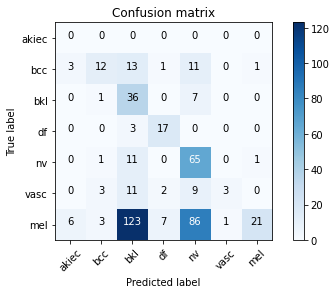

In [15]:

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
#         print("LABELS", labels)
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
#         print("Prediction", y_label, "\n", y_predict)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [16]:
# for idx, (data, image) in enumerate(validation_set):
#     print(idx)

In [ ]:
""" ------------------------------------------------------------------------------------------------------------------------
    Investigate the melenoma images in the "point" dataset and categorise them into their own categories
------------------------------------------------------------------------------------------------------------------------ """